In [1]:
import os
import sys
import argparse
import numpy as np
import torch
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm
import torch.nn as nn
import ants
import json

ModuleNotFoundError: No module named 'torch'

In [2]:
def pred_invert_resample(path_to_pred, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
    if np.shape(data)[0] == 1:
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
    
    # gbm and lgg
    elif np.shape(data)[0] > 1:
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
    return (output_file)

def pred_invert_resample_1cl(data, path_to_orig, path_to_resampled):
    # path_to_pred = *npz, path_to_orig = *1_reg, path_to_resampled = *4a_resample
    # *.npz archives sometimes can be recognised wrong, if extracted and saved back at the same time
#     data = np.load(path_to_pred, allow_pickle=True)['arr_0']
    # schw
        data = data.transpose(0,3,2,1).astype('float32')
        old_orig = ants.image_read(path_to_resampled)
        new_orig = ants.image_read(path_to_orig)
        old_like = old_orig.new_image_like(data[0])
        new_img = ants.resample_image(old_like, new_orig.spacing, False, 0)
        output_file = new_img.numpy().astype('float16')
        if new_orig.shape[0]-output_file.shape[0] < 0:
            output_file = output_file[:new_orig.shape[0], :new_orig.shape[1],:new_orig.shape[2] ]
        elif new_orig.shape[0]-output_file.shape[0] > 0:
            output_file = np.pad(output_file, ((0, new_orig.shape[0]-output_file.shape[0]), (0, new_orig.shape[1]-output_file.shape[1]), (0, new_orig.shape[2]-output_file.shape[2])), 'constant', constant_values=0)

        return (output_file)
    
def pred_invert_resample_classes(data, mat_file_path, path_to_orig, path_to_resampled, mod):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')
#         print(data.shape)
        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)
    
#         print(old_orig_ct1.shape)
#         print(new_orig_ct1.shape)
        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])
#         print('old_like')
# #         print(old_like_ch_2.shape)
        if mod == '2a_interp':
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.shape, True, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.shape, True, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.shape, True, 0)
        if mod == '3a_atlas':
            new_img_0 = ants.apply_transforms(new_orig_ct1, old_like_ch_0, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_1 = ants.apply_transforms(new_orig_ct1, old_like_ch_1, whichtoinvert=[True],
                                          transformlist = mat_file_path)
            new_img_2 = ants.apply_transforms(new_orig_ct1, old_like_ch_2, whichtoinvert=[True],
                                          transformlist = mat_file_path)
        else:
            new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.spacing, False, 0)
            new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.spacing, False, 0)
            new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.spacing, False, 0)
       
        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.astype('float16')
#         print(output_file.shape)
#         print('check_shape')
#         print(new_orig_ct1.shape)
#         print(new_orig_ct1.shape[2]-output_file.shape[3])
#         print((new_orig_ct1.shape[1]-output_file.shape[2]))
#         print((new_orig_ct1.shape[0]-output_file.shape[1]))
        if (new_orig_ct1.shape[2]-output_file.shape[3] < 0 ) or (new_orig_ct1.shape[1]-output_file.shape[2] < 0) or (new_orig_ct1.shape[0]-output_file.shape[1] < 0):
            print(1)
            output_file = output_file[:, :new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
            
        if (new_orig_ct1.shape[2]-output_file.shape[3] > 0) or (new_orig_ct1.shape[1]-output_file.shape[2] > 0 ) or (new_orig_ct1.shape[0]-output_file.shape[1] > 0):
            print(2)
            output_file = np.pad(output_file, ((0,0), (0, new_orig_ct1.shape[0]-output_file.shape[1]), (0, new_orig_ct1.shape[1]-output_file.shape[2]), (0, new_orig_ct1.shape[2]-output_file.shape[3])), 'constant', constant_values=0)

        output_file = output_file[:,:new_orig_ct1.shape[0], :new_orig_ct1.shape[1],:new_orig_ct1.shape[2] ]
#         print(output_file.shape)
        
        return (output_file)

In [3]:
def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)

In [4]:
def calculate_metrics_brats_1cl(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1'
                'Hausdorff95_1',
                'Sensitivity_1',
               'Specificity_1',
               'Surface_dice_1',
               'Precision_1']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    return df

def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
    
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask[0,:,:,:]==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask[1,:,:,:]==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
    distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
    df.at[0,'Dice_3'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Surface_dice_3'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_3'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Sensitivity_3'] = sens
    df.at[0,'Precision_3'] = precision
    df.at[0,'Specificity_3'] = spec
    return df

In [5]:
def calculate_metrics(subjects, path_to_file, path_to_orig, path_to_pred, path_to_resamp, path_to_target, dataset, out = '/home/polina/glioma/all_dice_metrics.csv', mod=None ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
#     _columns = ['Ids','Dice_1'
#                 'Hausdorff95_1',
#                 'Sensitivity_1',
#                'Specificity_1',
#                'Surface_dice_1',
#                'Precision_1']
    
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    orig_folder = Path(path_to_orig)
    resamp_folder = Path(path_to_resamp)
    target_folder = Path(path_to_target)
    file_folder = Path(path_to_file)
    for ids in tqdm(subjects):
        print(ids)
        pred_sub = os.path.join(pred_folder, ids + '.npy.npz')
        orig_sub = os.path.join(orig_folder, ids,'CT1_SEG.nii.gz')
        resamp_sub = os.path.join(resamp_folder, ids,'CT1_SEG.nii.gz')
        mat_fie_sub = os.path.join(file_folder, ids,'T1C_to_SRI_inv.mat')
#         targets = nib.load(os.path.join(target_folder, ids + '_seg.nii.gz'))
#         targets = ants.image_read(orig_sub)
#         targets = ants.reorient_image2(label_orig, orientation = 'LAI')
#         targets = nib.load(orig_sub)
#         spaces = targets.header.get_zooms()
#         spaces = targets.spacing
#         targets = targets.numpy().astype('int')
        targets = ants.image_read(f'{target_folder}/{ids}/CT1_SEG.nii.gz')
        spaces = targets.spacing
#         targets = ants.reorient_image2(targets, orientation = 'LAI').numpy()
        targets = targets.numpy()
#         print(targets.shape)
#         print(np.unique(targets))
        data = np.load(pred_sub, allow_pickle=True)['arr_0']
#         print(data.shape)
        if np.shape(data)[0] == 1: 
            prediction = pred_invert_resample_1cl(data,mat_fie_sub, orig_sub, resamp_sub, mod)
            prediction = np.round(prediction, 0)
#         pred = np.transpose(pred, (0, 3, 2, 1))
#             print(prediction.shape)
#             print(np.unique(prediction))
            df = calculate_metrics_brats_1cl(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             print(df)
        elif np.shape(data)[0] > 1: 
            prediction = pred_invert_resample_classes(data, mat_fie_sub, orig_sub, resamp_sub, mod)
#             prediction = data.transpose(0,3,2,1).astype('float32')
            prediction = np.round(prediction, 0)
            y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
            targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
            print(targets.shape)
#             print(prediction.shape)
            df=calculate_metrics_brats(targets.astype('int'), prediction.astype('int'), ids, spaces)
#             except:
#                 continue
        os.makedirs(os.path.join(out, dataset,ids), exist_ok = True)
        out_path = os.path.join(out, dataset,ids, path_to_pred.split('/')[-2] + '_'+ path_to_pred.split('best_')[-1].replace('=', '_') + '.json')
       #         df.to_json(out_path, orient='records')
        sub_dict = {dataset : {path_to_pred.split('/')[-2]: {path_to_pred.split('_')[-2]: {}}}}
        sub_dict[dataset][path_to_pred.split('/')[-2]][path_to_pred.split('_')[-2]] = df.to_dict('records')[0]
#         print(sub_dict)
        with open(out_path, 'w') as fp:
            json.dump(sub_dict, fp)
#         print(df)
        af_all = af_all.append(df)
#     af_all.to_csv(out)  
    print(af_all.mean())
    print(len(af_all))

In [46]:
a = os.listdir('/data/newdata/gbm_infer/gbm_2a_interp_unetr/predictions_best_epoch=141-dice_mean=66_89_task=22_fold=1_tta')
b = os.listdir('/data/newdata/gbm_infer/gbm_2a_interp_unetr/predictions_best_epoch=192-dice_mean=72_22_task=22_fold=0_tta')
for each in b:
    if each not in a:
        print(each)

TCGA-06-0190.npy.npz


In [48]:
!cd /results/gbm_infer/gbm_4a_resamp/predictions_best_epoch=197-dice_mean=78_14_task=38_fold=0_tta && ls -l

total 3150012
-rw-r--r-- 1 root root 22591696 Jun 22 13:43 TCGA-02-0006.npy.npz
-rw-r--r-- 1 root root 21948412 Jun 22 13:44 TCGA-02-0009.npy.npz
-rw-r--r-- 1 root root 17656859 Jun 22 13:44 TCGA-02-0011.npy.npz
-rw-r--r-- 1 root root 41247468 Jun 22 13:44 TCGA-02-0027.npy.npz
-rw-r--r-- 1 root root 20650110 Jun 22 13:45 TCGA-02-0033.npy.npz
-rw-r--r-- 1 root root 21341763 Jun 22 13:45 TCGA-02-0034.npy.npz
-rw-r--r-- 1 root root 21871044 Jun 22 13:45 TCGA-02-0037.npy.npz
-rw-r--r-- 1 root root 19878099 Jun 22 13:45 TCGA-02-0046.npy.npz
-rw-r--r-- 1 root root 19352613 Jun 22 13:46 TCGA-02-0047.npy.npz
-rw-r--r-- 1 root root 20244642 Jun 22 13:46 TCGA-02-0054.npy.npz
-rw-r--r-- 1 root root 29894458 Jun 22 13:46 TCGA-02-0059.npy.npz
-rw-r--r-- 1 root root 42257456 Jun 22 13:46 TCGA-02-0064.npy.npz
-rw-r--r-- 1 root root 25843515 Jun 22 13:47 TCGA-02-0068.npy.npz
-rw-r--r-- 1 root root 36960401 Jun 22 13:47 TCGA-02-0069.npy.npz
-rw-r--r-- 1 root root 28722993 Jun 22 13:47 TCGA-02-0070.npy.

In [12]:
len(os.listdir('/data/newdata/gbm_infer/gbm_4a_resamp_from_bgpd_TL/predictions_best_epoch=56-dice_mean=81_56_task=38_fold=0_tta'))

102

In [36]:
orig_folder = '/data_anvar/public_datasets/preproc_study/gbm/orig'
resample_folder = '/data_anvar/public_datasets/preproc_study/gbm/4a_resamp'
file = '/data_anvar/public_datasets/preproc_study/gbm/3a_atlas'
pred_folder = '/data/newdata/gbm_infer/gbm_5_ss_shared_from_bgpd_TL/predictions_best_epoch=40-dice_mean=82_24_task=28_fold=2_tta'
target_folder = '/data_anvar/public_datasets/preproc_study/gbm/1_reg'
reg_1 = '/data_anvar/public_datasets/preproc_study/gbm/1_reg'
out_json = '/results/metrics'
dataset = 'gbm'
# TCGA-76-4932
subjects = [each[:-8] for each in os.listdir(pred_folder)]
assert(len(subjects) == 102)
# subjects = ['TCGA-02-0027']
calculate_metrics(subjects, file, reg_1, pred_folder, resample_folder, target_folder, dataset, out = out_json)

  0%|                                                                       | 0/102 [00:00<?, ?it/s]

TCGA-02-0054


TypeError: pred_invert_resample_1cl() takes 3 positional arguments but 5 were given

In [8]:
import ants
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
fname = 'TCGA-19-5954'
#             Ids    Dice_1   Dice_2    Dice_3 Hausdorff95_1 Hausdorff95_2  \
# 0  TCGA-12-3650  0.879787  0.36124  0.736353 
img_orig = ants.image_read(f"/data/private_data/gbm/gbm_3a_atlas/images/{fname}.nii.gz").numpy()
# img_orig = np.load(f"/data/private_data/gbm/20_3d/{fname}_x.npy").transpose(3,2,1,0)
# label_orig = np.load(f"/data/private_data/gbm/20_3d/{fname}_y.npy").transpose(0,3,2,1).squeeze()
label_orig = ants.image_read(f"/data/private_data/gbm/gbm_3a_atlas/labels/{fname}_seg.nii.gz").numpy()
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
# spaces = label_orig.header.get_zooms()
# print(spaces)
# label_orig = label_orig.get_fdata().astype(np.uint8)
l = np.argsort(label_orig.sum(axis=(0,1)))[-1:]
# label_orig = ants.reorient_image2(ants.from_numpy(label_orig), orientation = 'LAS').numpy() 
y_wt, y_tc, y_et = label_orig > 0, ((label_orig == 1) + (label_orig == 3)) > 0, label_orig == 3
label_orig = np.stack([y_wt, y_tc, y_et], axis=0).astype(int).transpose(1,2,3,0)
print(l)
orig_sub = os.path.join('/data_anvar/public_datasets/preproc_study/gbm/1_reg', fname,'CT1_SEG.nii.gz')
resamp_sub = os.path.join('/data_anvar/public_datasets/preproc_study/gbm/2a_interp', fname,'CT1_SEG.nii.gz')
mat_fie_sub = os.path.join('/data_anvar/public_datasets/preproc_study/gbm/3a_atlas', fname,'T1C_to_SRI_inv.mat')
pred = np.load(f'/results/gbm_infer/gbm_3a_atlas/predictions_best_epoch=70-dice_mean=71_68_task=20_fold=1_tta/{fname}.npy.npz')['arr_0']
# p = np.round(pred, 0).transpose(3,2,1,0).astype(np.uint8)
prediction = pred_invert_resample_classes(pred, mat_fie_sub, orig_sub, resamp_sub)
#             prediction = data.transpose(0,3,2,1).astype('float32')
p = np.round(prediction, 0).transpose(3,2,1,0).astype(np.uint8)
print(label_orig.shape), print(img_orig.shape)
print(np.unique(label_orig))
print(p.shape), print(np.unique(p))
# print(mask.shape), print(np.unique(mask))
# print((p[:,:,:,0]* mask).shape)
# check = np.concatenate(((p[:,:,:,0]* mask)[:,:,:,np.newaxis], (p[:,:,:,1]* mask)[:,:,:,np.newaxis], (p[:,:,:,2]* mask)[:,:,:,np.newaxis]), axis=3)
# print(check.shape), print(np.unique(check))
imgs = [img_orig[:, :, l, i] for i in [0,3]] + [label_orig[:,:,l,0]]  +[p[:,:,l,0]] +[label_orig[:,:,l,1]] +  [p[:,:,l,1]]+ [label_orig[:,:,l,2]] +[p[:,:,l,2]]
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(12, 12))

for i in range(8):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
plt.tight_layout()            
plt.show()

# print(fname)
# print('dice WT')
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (p[:,:,:,0]==1)))
# # print(metrics.compute_dice_coefficient((label_orig[:,:,:,0]==1), (check[:,:,:,0]==1)))
# print('Dice_2')
# print(metrics.
#       compute_dice_coefficient((label_orig[:,:,:,1]==1), (p[:,:,:,1]==1)))
# # print(metrics.compute_dice_coefficient((label_orig[:,:,:,1]==1), (check[:,:,:,1]==1)))
# print('Dice_3')
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (p[:,:,:,2]==1)))
# print(metrics.compute_dice_coefficient((label_orig[:,:,:,2]==1), (check[:,:,:,2]==1)))

(240, 240, 155)
(240, 240, 155, 4)
[0. 1. 2. 3.]
[79]


TypeError: pred_invert_resample_classes() missing 1 required positional argument: 'mod'

In [ ]:
out_json = '/results/metrics/gbm/'
dataset = 'gbm'
task = 'gbm_4a_resamp_aug'
fold = 'fold_2'
_columns = ['Ids','Dice_1', 'Dice_2', 'Dice_3',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_3',
                'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_3',
               'Specificity_1', 'Specificity_2', 'Specificity_3',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_3',
               'Precision_1', 'Precision_2', 'Precision_3']
metrics_all = pd.DataFrame(columns = _columns)
for i,sub in tqdm((enumerate(os.listdir(out_json)))):
    for sub_t in os.listdir(os.path.join(out_json, sub)):
        if f'{task}_epoch' in sub_t:
            if fold in sub_t:
#                 print(i)
#                 print(os.path.join(out_json, sub, sub_t))
                metrics = json.load(open(os.path.join(out_json, sub, sub_t)))
#                 print(metrics)
                metrics = metrics[dataset][task][fold.replace('_', '=')]
                for each in metrics:
                    metrics_all[each]
                    metrics_all.at[i,'Ids'] = sub
                    metrics_all.at[i,'Dice_1'] = metrics['Dice_1']   
                    metrics_all.at[i,'Dice_2'] = metrics['Dice_2']
                    metrics_all.at[i,'Dice_3'] = metrics['Dice_3']
                    metrics_all.at[i,'Hausdorff95_1'] = metrics['Hausdorff95_1']
                    metrics_all.at[i,'Hausdorff95_2'] = metrics['Hausdorff95_2']
                    metrics_all.at[i,'Hausdorff95_3'] = metrics['Hausdorff95_3']
                    metrics_all.at[i,'Sensitivity_1'] = metrics['Sensitivity_1']
                    metrics_all.at[i,'Sensitivity_2'] = metrics['Sensitivity_2']
                    metrics_all.at[i,'Sensitivity_3'] = metrics['Sensitivity_3']
                    metrics_all.at[i,'Specificity_1'] = metrics['Specificity_1']
                    metrics_all.at[i,'Specificity_2'] = metrics['Specificity_2']
                    metrics_all.at[i,'Specificity_3'] = metrics['Specificity_3']
                    metrics_all.at[i,'Surface_dice_1'] = metrics['Surface_dice_1']
                    metrics_all.at[i,'Surface_dice_2'] = metrics['Surface_dice_2']
                    metrics_all.at[i,'Surface_dice_3'] = metrics['Surface_dice_3']
                    metrics_all.at[i,'Precision_1'] = metrics['Precision_1']
                    metrics_all.at[i,'Precision_2'] = metrics['Precision_2']
                    metrics_all.at[i,'Precision_3'] = metrics['Precision_3']
                    
print(len(metrics_all))
print(metrics_all.mean())
print(metrics_all.std())


In [42]:
metrics_all[metrics_all.Dice_3<0.50]

,Ids,Dice_1,Dice_2,Dice_3,Hausdorff95_1,Hausdorff95_2,Hausdorff95_3,Sensitivity_1,Sensitivity_2,Sensitivity_3,Specificity_1,Specificity_2,Specificity_3,Surface_dice_1,Surface_dice_2,Surface_dice_3,Precision_1,Precision_2,Precision_3
14,TCGA-06-6389,0.62345,0.42666,0.448001,65.69915,99.49474,99.396808,0.915387,0.841837,0.855159,0.995475,0.996877,0.997721,0.408754,0.32986,0.477779,0.472697,0.285739,0.303499
16,TCGA-76-6285,0.768172,0.678038,0.437453,7.139787,7.322109,6.760409,0.753586,0.62919,0.4687,0.998863,0.999254,0.998716,0.595938,0.509789,0.718157,0.783333,0.73511,0.410112
19,TCGA-19-2624,0.676742,0.605391,0.176937,17.578396,15.524175,11.090537,0.598833,0.577451,0.21816,0.997665,0.999008,0.999411,0.224775,0.272653,0.395091,0.777955,0.636172,0.148816
25,TCGA-02-0006,0.835456,0.483791,0.444444,6.546782,5.949823,4.941059,0.749091,0.360595,0.331839,0.999708,0.999954,0.999952,0.734871,0.496046,0.625227,0.944331,0.734848,0.672727
46,TCGA-76-4932,0.727376,0.645647,0.101815,9.101487,12.066968,13.11779,0.648176,0.51595,0.059118,0.998672,0.999453,0.99964,0.512728,0.414375,0.273758,0.828625,0.862442,0.366577
48,TCGA-19-0963,0.682694,0.693392,0.280942,22.348257,17.016909,22.5,0.610287,0.678606,0.48227,0.995452,0.995371,0.988661,0.343607,0.416231,0.430406,0.774597,0.708837,0.198202
62,TCGA-19-5954,0.414719,0.0,0.0,19.949937,34.539832,34.014703,0.32604,0.0,0.0,0.996927,0.998858,0.999291,0.22232,0.0,0.0,0.569661,0.0,0.0
77,TCGA-19-5958,0.586443,0.680615,0.243965,18.220867,9.949874,8.831761,0.529566,0.585475,0.206271,0.996656,0.999323,0.998956,0.242718,0.253794,0.437427,0.657007,0.812674,0.298518
95,TCGA-76-6664,0.922574,0.139716,0.32342,4.38197,24.321983,26.226408,0.882124,0.410128,0.374462,0.999503,0.991982,0.998633,0.823872,0.160374,0.398764,0.966912,0.0842,0.284624
98,TCGA-08-0356,0.735796,0.586037,0.474427,119.212918,121.056244,121.769755,0.913365,0.728273,0.624926,0.996946,0.997809,0.997894,0.482934,0.197085,0.357876,0.616032,0.490282,0.382348


<AxesSubplot:>

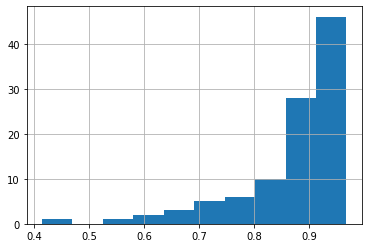

In [38]:
metrics_all.Dice_1.hist()

<AxesSubplot:>

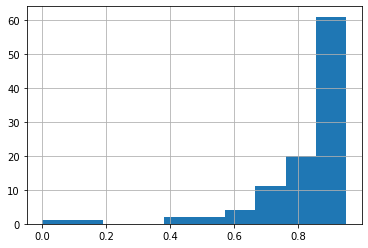

In [39]:
metrics_all.Dice_2.hist()

<AxesSubplot:>

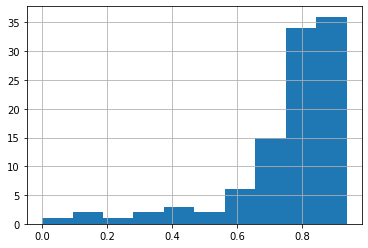

In [40]:
metrics_all.Dice_3.hist()

Text(0.5, 1.0, 'Dice_3')

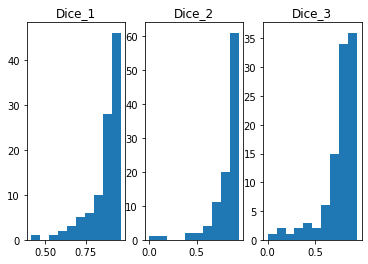

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3)
n_bins = len(metrics_all)
axs[0].hist(metrics_all['Dice_1'])
axs[0].set_title('Dice_1')
axs[1].hist(metrics_all['Dice_2'])
axs[1].set_title('Dice_2')
axs[2].hist(metrics_all['Dice_3'])
axs[2].set_title('Dice_3')

In [25]:
!cd /results/metrics/gbm/TCGA-02-0033 && ls

gbm_1_reg_train_epoch_139-dice_mean_77_36_task_21_fold_2_tta.json
gbm_1_reg_train_epoch_208-dice_mean_76_71_task_21_fold_1_tta.json
gbm_1_reg_train_epoch_212-dice_mean_82_10_task_21_fold_0_tta.json
gbm_4a_resamp_aug_epoch_165-dice_mean_73_37_task_38_fold_1_tta.json
gbm_4a_resamp_aug_epoch_204-dice_mean_75_77_task_38_fold_2_tta.json
gbm_4a_resamp_aug_epoch_79-dice_mean_75_09_task_38_fold_0_tta.json
gbm_4a_resamp_epoch_191-dice_mean_72_90_task_38_fold_1_tta.json
gbm_4a_resamp_epoch_197-dice_mean_78_14_task_38_fold_0_tta.json
gbm_4a_resamp_epoch_198-dice_mean_75_08_task_38_fold_2_tta.json
gbm_4a_resamp_unetr_param_epoch_171-dice_mean_68_44_task_38_fold_1_tta.json
gbm_4a_resamp_unetr_param_epoch_258-dice_mean_74_40_task_38_fold_0_tta.json
gbm_4a_resamp_unetr_param_epoch_268-dice_mean_73_03_task_38_fold_2_tta.json
gbm_4a_resamp_wo_z_epoch_146-dice_mean_76_62_task_43_fold_0_tta.json
gbm_4a_resamp_wo_z_epoch_157-dice_mean_73_33_task_43_fold_1_tta.json
gbm_4a_resamp_wo_z_epoch_203-dice_mean_74